# vqgan-jax-encoding-yfcc100m

Encoding notebook for YFCC100M.

This dataset was prepared by @borisdayma in Json lines format. This version assumes that all images are available in the filesystem.

In [1]:
import io

import requests
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
import os

import jax
from jax import pmap

Verify that JAX is seeing our devices correctly.

In [2]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Dataset and Parameters

In [3]:
from pathlib import Path

In [4]:
yfcc100m = Path('/yfcc')
# Images are 'sharded' from the following directory
yfcc100m_images = yfcc100m/'data'/'images'
yfcc100m_metadata = yfcc100m/'metadata'
yfcc100m_filtered = yfcc100m/'metadata_filtered.jsonl'
yfcc100m_output = yfcc100m/'encoded'      # Output directory for encoded files

In [5]:
batch_size = 128      # Per device
num_workers = 16

In [6]:
import datasets
from datasets import Dataset, load_dataset

### Cleanup and preparation

We'll filter out entries referring to:
* Very small or inexistent files.
* Images that are smaller than 256 pixels in either dimension.
* Malformed images. They can be read using `ImageFile.LOAD_TRUNCATED_IMAGES = True`, but we'd rather ignore them.

Examining the image size and opening them to make sure they are not malformed is much slower than just verifying the files. If in a hurry we could just ignore the empty ones and load everything with `ImageFile.LOAD_TRUNCATED_IMAGES`.

Small images sometimes have long aspect ratios, making them less suitable for center cropping. See the following one, for example. Of course, we should do some data analysis on all of the images at some point.

In [7]:
def image_for(key):
    image_path = (yfcc100m_images/key[0:3]/key[3:6]/key).with_suffix(".jpg")
    return Image.open(image_path)

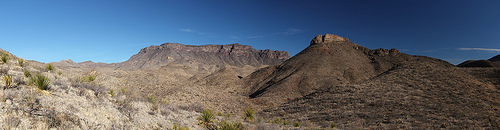

(500, 130)


In [8]:
img = image_for('782865f3fc4b493fd7ca2821f452ed0')
display(img)
print(img.size)

In [9]:
from torchvision.datasets.folder import default_loader

def image_is_valid(path, key, ext='jpg'):
    image_path = (path/key[0:3]/key[3:6]/key).with_suffix("." + ext)
    try:
        if image_path.lstat().st_size < 16384:
            return False
        image = default_loader(image_path)
        return min(image.size) >= 256
    except:
        return False   # Does not exist

In [10]:
import string

def create_caption(title, description):
    title = title.strip()
    description = description.strip()
    if len(title) > 0 and title[-1] not in '.!?': title += '.'
    return f'{title} {description}'

In [8]:
def filter_and_prepare(examples):
    result = {'key': [], 'caption': []}
    for (key, title, description) in zip(examples['key'], examples['title_clean'], examples['description_clean']):
        if image_is_valid(yfcc100m_images, key):
            result['key'].append(key)
            result['caption'].append(create_caption(title, description))
    return result

In [9]:
import glob

if not yfcc100m_filtered.exists():
    metadata_files = glob.glob(str(yfcc100m_metadata/"*.jsonl.gz"))
    dataset = load_dataset('json', data_files=metadata_files, split='train')
    filtered = dataset.map(filter_and_prepare, batched=True, num_proc=num_workers, remove_columns=dataset.column_names)
    print(f"Using {len(filtered)} / {len(dataset)} items.")
    filtered.to_json(yfcc100m_filtered)

In [10]:
dataset = load_dataset('json', data_files=str(yfcc100m_filtered), split='train')

## Torch Dataset and DataLoader

We'll create a PyTorch Dataset and a DataLoader for convenience. This allows us to resize images when we retrieve items, and easily take batches of our desired size. An alternative would be to use a data collator instead.

This is our simple PyTorch `Dataset` implementation. It simply reads images and center crops them.

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from PIL import ImageFile

class YFCCDataset(Dataset):
    def __init__(self, *, images_root, dataset: Dataset, max_len=None):
        self.images_root = Path(images_root)
        self.dataset = dataset
        self.size = min(len(self.dataset), max_len) if max_len is not None else len(self.dataset)
    
    def _get_raw_image(self, i):
        key = self.dataset[i]['key']
        image_path = (self.images_root/key[0:3]/key[3:6]/key).with_suffix(".jpg")
        image = default_loader(image_path)
        return image
    
    def _center_crop(self, image, max_size=256):
        s = min(image.size)
        r = max_size / s
        s = (round(r * image.size[1]), round(r * image.size[0]))
        image = TF.resize(image, s, interpolation=InterpolationMode.LANCZOS)
        image = TF.center_crop(image, output_size=2 * [max_size])
        image = torch.unsqueeze(T.ToTensor()(image), 0)
        return image.permute(0, 2, 3, 1).numpy()

    def __getitem__(self, i):
        image = self._get_raw_image(i)
        image = self._center_crop(image)
        return image

    def __len__(self):
        return self.size

## VQGAN-JAX model

In [12]:
from vqgan_jax.modeling_flax_vqgan import VQModel

We'll use a VQGAN trained with Taming Transformers and converted to a JAX model.

In [13]:
model = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


## Encoding

Encoding is really simple using `shard` to automatically distribute "superbatches" across devices, and `pmap`. This is all it takes to create our encoding function, that will be jitted on first use.

In [14]:
from flax.training.common_utils import shard
from functools import partial

In [15]:
@partial(jax.pmap, axis_name="batch")
def encode(batch):
    # Not sure if we should `replicate` params, does not seem to have any effect
    _, indices = model.encode(batch)
    return indices

## Putting it all together

In [33]:
import os
import pandas as pd

def encode_captioned_dataset(dataset, output_dir, batch_size=32, num_workers=16, save_every=14):
    output_dir.mkdir(parents=True, exist_ok=True)
    
    num_tpus = jax.device_count()
    bs = batch_size * num_tpus
    torch_dataset = YFCCDataset(images_root=yfcc100m_images, dataset=dataset)
    dataloader = DataLoader(torch_dataset, batch_size=bs, num_workers=num_workers)
    
    # Saving strategy:
    # - Create a new file every so often to prevent excessive file seeking.
    # - Save each batch after processing.
    # - Keep the file open until we are done with it.
    file = None        
    iterations = len(dataset) // bs
    iter_loader = iter(dataloader)
    for n in tqdm(range(iterations)):
        if (n % save_every == 0):
            if file is not None:
                file.close()
            split_num = n // save_every
            file = open(output_dir/f'split_{split_num:05x}.jsonl', 'w')
        batch = next(iter_loader).numpy()
        batch = shard(batch.squeeze())
        encoded = encode(batch)
        encoded = encoded.reshape(-1, encoded.shape[-1])

        # Extract captions from the dataset
        start_index = n * batch_size * num_tpus
        end_index = (n+1) * batch_size * num_tpus
        
        # Watch out! getting the column and then indexing is much slower than getting the slice first and then accessing the column
        keys = dataset[start_index:end_index]["key"]
        captions = dataset[start_index:end_index]["caption"]
        
        encoded_as_string = list(map(lambda item: np.array2string(item, separator=',', max_line_width=50000, formatter={'int':lambda x: str(x)}), encoded))
        batch_df = pd.DataFrame.from_dict({"key": keys, "caption": captions, "encoding": encoded_as_string})
        batch_df.to_json(file, orient='records', lines=True)

Create a new file every 318 iterations. This should produce splits of ~500 MB each, when using a total batch size of 1024.

In [34]:
save_every = 318

In [35]:
encode_captioned_dataset(dataset, yfcc100m_output, batch_size=batch_size, num_workers=num_workers, save_every=save_every)

100%|█████████████████████████████████████████████████████| 14462/14462 [3:56:55<00:00,  1.02it/s]


----